# Demo 1: Using Pre-trained Vision-Language Models

**Learning Objectives:**
- Load and use state-of-the-art VLMs from Hugging Face
- Perform image captioning with BLIP-2
- Answer visual questions with LLaVA
- Conduct image-text retrieval with CLIP
- Understand inference pipelines and best practices

**Estimated Time:** 45-60 minutes

**Requirements:**
- Google Colab with T4 GPU (free tier) or local GPU with 16GB+ VRAM
- Internet connection for downloading models

## 1. Environment Setup

First, let's install the required libraries and verify GPU availability.

In [1]:
# Install required packages
!pip install -q transformers accelerate pillow requests torch torchvision
!pip install -q bitsandbytes  # For efficient loading

print("✓ All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.9 MB/s eta 0:00:00
✓ All packages installed successfully!


In [2]:
# Import libraries
import torch
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from transformers import (
    AutoProcessor,
    AutoModelForCausalLM,
    Blip2Processor,
    Blip2ForConditionalGeneration,
    CLIPProcessor,
    CLIPModel,
)

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ Warning: Running on CPU. Inference will be slow.")

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


### Helper Functions

Let's create utility functions for loading and displaying images.

In [3]:
def load_image(image_path_or_url):
    """
    Load an image from a local path or URL.

    Args:
        image_path_or_url: Local file path or HTTP(S) URL

    Returns:
        PIL Image object
    """
    if image_path_or_url.startswith(('http://', 'https://')):
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_path_or_url).convert('RGB')
    return image

def display_image(image, title=None, figsize=(8, 6)):
    """
    Display an image with optional title.

    Args:
        image: PIL Image object
        title: Optional title string
        figsize: Figure size tuple (width, height)
    """
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14, fontweight='bold')
    plt.show()

print("✓ Helper functions defined")

✓ Helper functions defined


### Load Sample Images

We'll use some example images from the web for demonstration.

Loading images from microsoft/cats_vs_dogs dataset...


README.md: 0.00B [00:00, ?B/s]

✓ Loaded cat image from dataset
✓ Loaded dog image from dataset


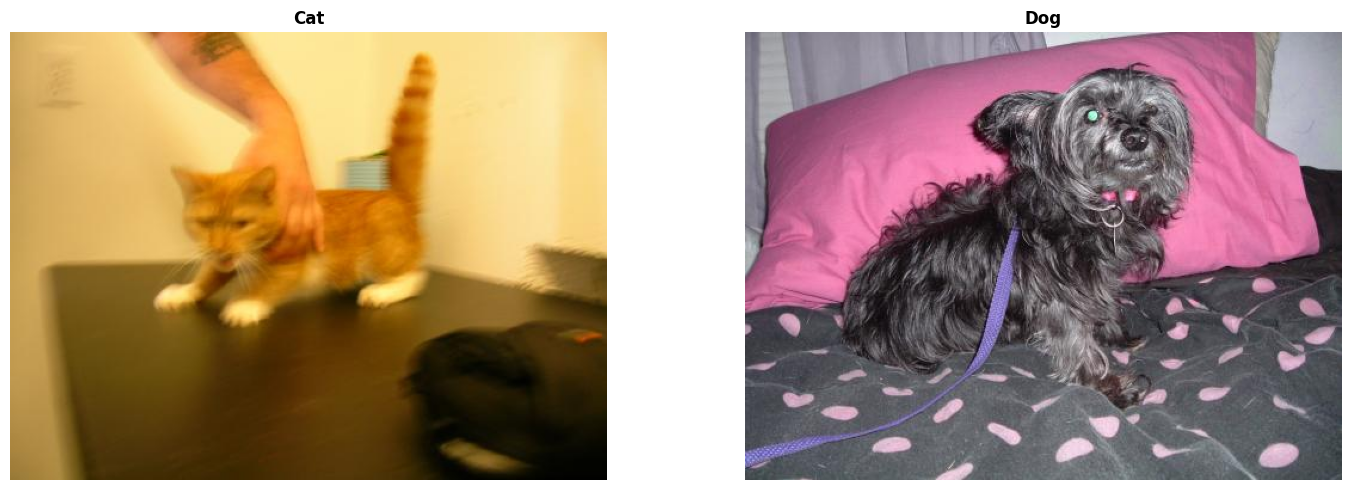

In [4]:
from datasets import load_dataset

print("Loading images from microsoft/cats_vs_dogs dataset...")

# Load dataset in streaming mode to avoid downloading the entire dataset
dataset = load_dataset("microsoft/cats_vs_dogs", split="train", streaming=True)

images = {}

# Iterate through the dataset to find one cat and one dog
# Labels: 0 = Cat, 1 = Dog
for example in dataset:
    label = example['labels']
    if 'cat' not in images and label == 0:
        images['cat'] = example['image'].convert("RGB")
        print("✓ Loaded cat image from dataset")
    elif 'dog' not in images and label == 1:
        images['dog'] = example['image'].convert("RGB")
        print("✓ Loaded dog image from dataset")

    if 'cat' in images and 'dog' in images:
        break

# Display sample images
if len(images) > 0:
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:
        axes = [axes]
    for ax, (name, img) in zip(axes, images.items()):
        ax.imshow(img)
        ax.set_title(name.capitalize(), fontsize=12, fontweight='bold')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No images loaded to display.")

## 2. Image Captioning with BLIP-2

BLIP-2 is a model for image captioning that uses a lightweight Q-Former to bridge vision and language.

**Key Concepts (from Module 2):**
- Q-Former extracts visual features using learnable queries
- Queries act as information bottleneck
- Connected to frozen LLM for generation

In [5]:
# Load BLIP-2 model
print("Loading BLIP-2 model... (this may take a few minutes)")

blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16,  # Use FP16 for efficiency
    device_map="auto"  # Automatically map to available devices
)

print("✓ BLIP-2 model loaded successfully")
print(f"Model size: {sum(p.numel() for p in blip_model.parameters()) / 1e9:.2f}B parameters")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP-2 model... (this may take a few minutes)


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

✓ BLIP-2 model loaded successfully
Model size: 3.74B parameters


### Generate Captions with Different Decoding Strategies


CAPTION GENERATION COMPARISON

GREEDY         : a small black dog sitting on a bed with a pink pillow
BEAM_SEARCH    : a small black dog sitting on a bed with a pink pillow
NUCLEUS        : a small gray dog with green eyes on a pink pillow


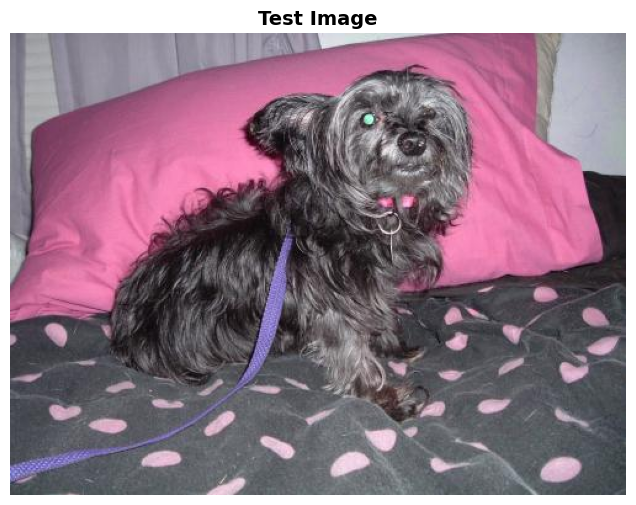

In [6]:
def generate_caption(image, decoding_strategy="greedy", max_length=50):
    """
    Generate caption for an image using BLIP-2.

    Args:
        image: PIL Image
        decoding_strategy: One of ["greedy", "beam_search", "nucleus"]
        max_length: Maximum caption length

    Returns:
        Generated caption string
    """
    # Process image
    inputs = blip_processor(images=image, return_tensors="pt").to(device, torch.float16)

    # Generate based on strategy
    if decoding_strategy == "greedy":
        # Greedy: Select most probable token at each step
        generated_ids = blip_model.generate(
            **inputs,
            max_length=max_length,
            do_sample=False  # Deterministic
        )
    elif decoding_strategy == "beam_search":
        # Beam search: Keep top-k candidates
        generated_ids = blip_model.generate(
            **inputs,
            max_length=max_length,
            num_beams=5,  # Number of beams
            do_sample=False
        )
    elif decoding_strategy == "nucleus":
        # Nucleus (top-p) sampling: Sample from top cumulative probability
        generated_ids = blip_model.generate(
            **inputs,
            max_length=max_length,
            do_sample=True,
            top_p=0.9,  # Nucleus probability
            temperature=1.0  # Sampling temperature
        )
    else:
        raise ValueError(f"Unknown strategy: {decoding_strategy}")

    # Decode to text
    caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    return caption

# Test different decoding strategies
test_image = images["dog"]

print("\n" + "="*60)
print("CAPTION GENERATION COMPARISON")
print("="*60 + "\n")

for strategy in ["greedy", "beam_search", "nucleus"]:
    caption = generate_caption(test_image, decoding_strategy=strategy)
    print(f"{strategy.upper():15s}: {caption}")

display_image(test_image, "Test Image")

### Caption All Sample Images


CAT:
  Caption: an orange and white cat is standing on a table

DOG:
  Caption: a small black dog sitting on a bed with a pink pillow


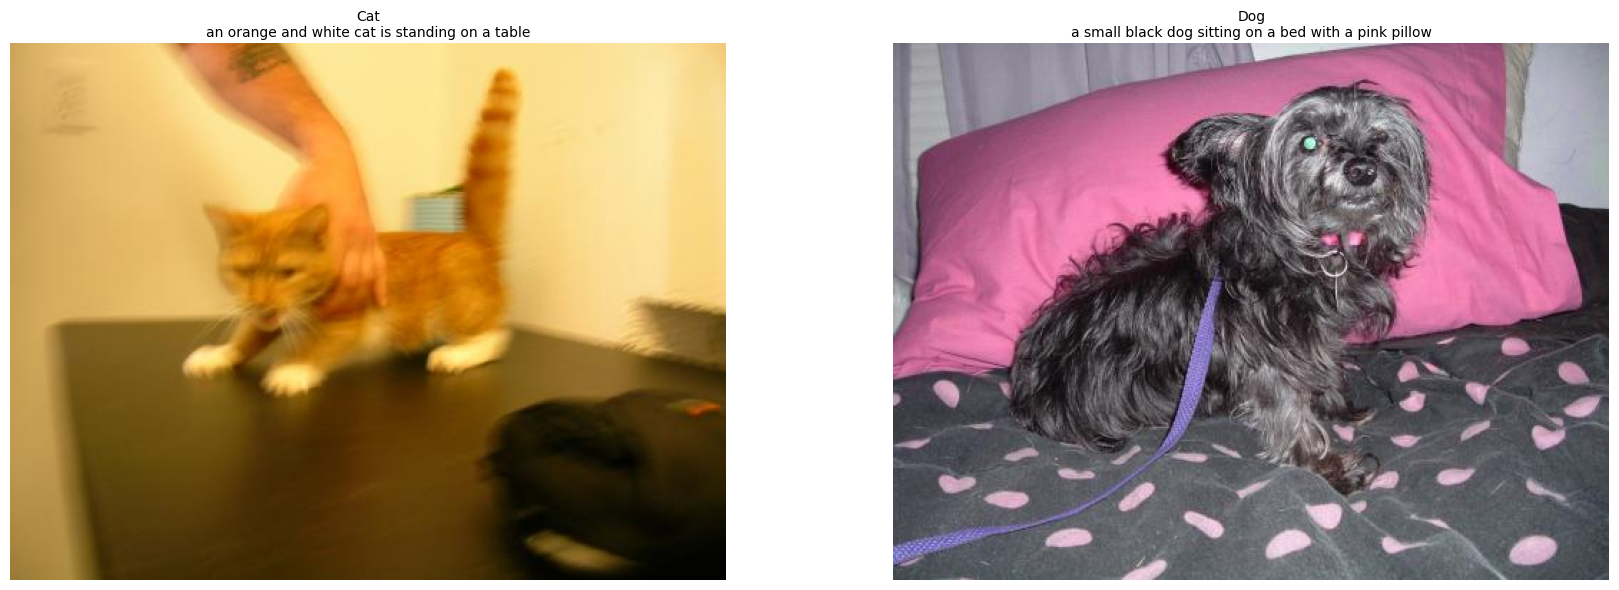

In [7]:
# Generate captions for all images
captions = {}

for name, image in images.items():
    caption = generate_caption(image, decoding_strategy="beam_search")
    captions[name] = caption
    print(f"\n{name.upper()}:")
    print(f"  Caption: {caption}")

# Visualize images with captions
fig, axes = plt.subplots(1, len(images), figsize=(18, 6))
for ax, (name, img) in zip(axes, images.items()):
    ax.imshow(img)
    ax.set_title(f"{name.capitalize()}\n{captions[name]}",
                 fontsize=10, wrap=True)
    ax.axis('off')
plt.tight_layout()
plt.show()

### Single-Turn VQA

In [8]:
def answer_question(image, question, max_new_tokens=20):
    """
    Answer a question about an image using BLIP-2.

    Args:
        image: PIL Image
        question: Question string
        max_new_tokens: Maximum tokens in answer

    Returns:
        Answer string
    """
    # Prepare prompt for VQA
    prompt = f"Question: {question} Answer:"

    # Process inputs
    inputs = blip_processor(images=image, text=prompt, return_tensors="pt").to(device, torch.float16)

    # Generate answer
    generated_ids = blip_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False
    )

    # Decode output
    answer = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return answer

# Test VQA on sample images
vqa_examples = [
    ("dog", "What breed is this dog?"),
    ("dog", "Is the dog sitting or standing?"),
    ("cat", "What color is the cat?"),
]

print("\n" + "="*60)
print("VISUAL QUESTION ANSWERING EXAMPLES (BLIP-2)")
print("="*60 + "\n")

for image_name, question in vqa_examples:
    if image_name in images:
        image = images[image_name]
        answer = answer_question(image, question)
        print(f"Image: {image_name.upper()}")
        print(f"Q: {question}")
        print(f"A: {answer}")
        print()
    else:
        print(f"Skipping {image_name}: Image not loaded.")


VISUAL QUESTION ANSWERING EXAMPLES (BLIP-2)

Image: DOG
Q: What breed is this dog?
A: Question: What breed is this dog? Answer: person

Image: DOG
Q: Is the dog sitting or standing?
A: Question: Is the dog sitting or standing? Answer: it's sitting

Image: CAT
Q: What color is the cat?
A: Question: What color is the cat? Answer: orange

